## De novo vs query mapping integration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import glob
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_Embedding_methods/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [11]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


### Run reference design comparison and parse results

See `submit_oor_design_v2.sh`

## Read outputs

In [43]:
def _read_oor_design(simdir, res_type = 'AUPRC', emb_method='scVI', diff_method = 'milo'):
    res_file = glob.glob(f'{simdir}/{res_type}_res.{emb_method}_{diff_method}.csv')
    assert len(res_file) == 1
    r = pd.read_csv(res_file[0], index_col=0)
    r['emb_method'] = emb_method
    r['diff_method'] = diff_method
    return(r)

In [44]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_') and not x.endswith("withOOR") and not x.endswith(".pkl")]

AUPRC_df = pd.DataFrame()
for d in dirs:
    for m in ['scVI', 'scArches']:
        try:
            r = _read_oor_design(outdir + d, emb_method = m)
            r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
        except AssertionError:
            continue
        AUPRC_df = pd.concat([AUPRC_df, r])
        
AUPRC_df['n_cells_subsample'] = 500

TPR_df = pd.DataFrame()
for d in dirs:
    for m in ['scVI', 'scArches']:
        try:
            r = _read_oor_design(outdir + d, emb_method = m, res_type='TPR')
        except AssertionError:
            continue
        TPR_df = pd.concat([TPR_df, r])
        
TPR_df['n_cells_subsample'] = 500

dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_1000cells_demo_perturb_cell_') and not x.endswith("withOOR") and not x.endswith(".pkl")]

for d in dirs:
    for m in ['scVI', 'scArches']:
        try:
            r = _read_oor_design(outdir + d, emb_method = m)
            r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
        except AssertionError:
            continue
        AUPRC_df = pd.concat([AUPRC_df, r])

for d in dirs:
    for m in ['scVI', 'scArches']:
        try:
            r = _read_oor_design(outdir + d, emb_method = m, res_type='TPR')
        except AssertionError:
            continue
        TPR_df = pd.concat([TPR_df, r])

/tmp/ipykernel_25126/3418219114.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_25126/3418219114.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_25126/3418219114.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_25126/3418219114.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
/tmp/ipykernel_25126/3418219114.py:9: FutureWarning: In a future version of pandas a

In [45]:
TPR_df.loc[TPR_df['n_cells_subsample'].isna(), 'n_cells_subsample'] = 1000
AUPRC_df.loc[AUPRC_df['n_cells_subsample'].isna(), 'n_cells_subsample'] = 1000

## Plot metrics

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


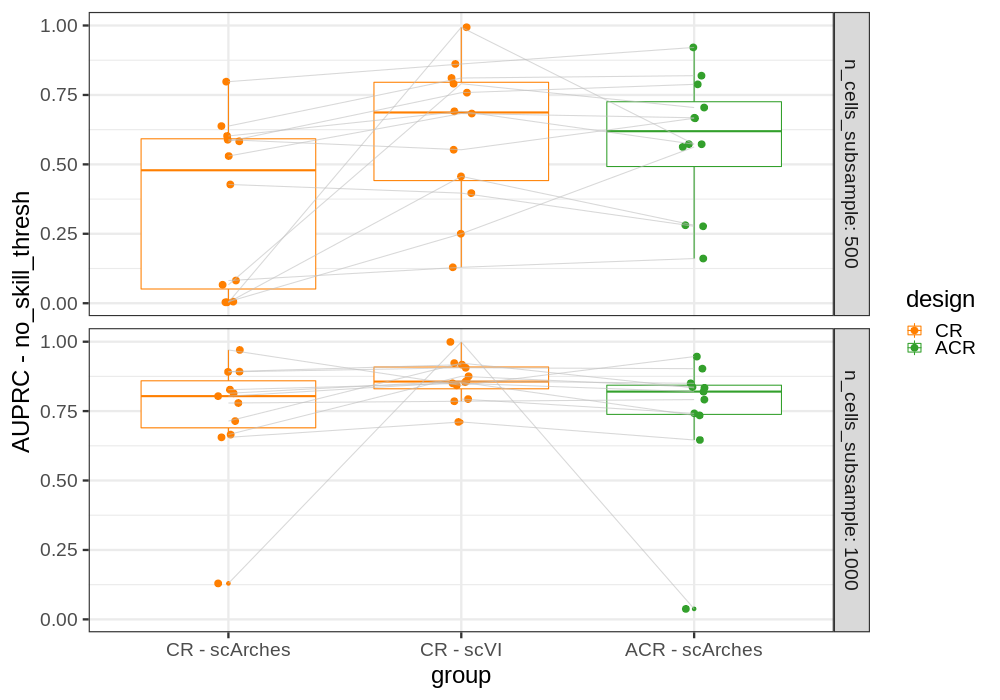

In [61]:
%%R -i AUPRC_df -w 1000 -h 700
AUPRC_df %>%
    filter(!OOR_state_name %in% c('neutrophil', 'plasmablast', 'erythrocyte', 'plasmacytoid_dendritic_cell')) %>%
    mutate(`Emb method` = emb_method) %>%
    mutate(group = paste(design, '-', emb_method)) %>%
    mutate(design = factor(design, levels=c('AR', "CR", 'ACR'))) %>%
    filter(group %in% c('CR - scArches', 'CR - scVI', 'ACR - scArches')) %>%
    mutate(group=factor(group, levels=c('CR - scArches', 'CR - scVI', 'ACR - scArches'))) %>%
    ggplot(aes(group, AUPRC - no_skill_thresh, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    scale_color_brewer(palette='Accent', 
                       labels=c(logFC='DA logFC (ACR design)', 
                           mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                           mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
    theme_bw(base_size=24) +
    facet_grid(n_cells_subsample~., labeller='label_both') +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) 
#     ggsave(paste0(figdir, 'AUPRC_boxplot_design.png'), width=12, height=5) +
#     ggsave(paste0(figdir, 'AUPRC_boxplot_design.pdf'), width=12, height=5)



/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


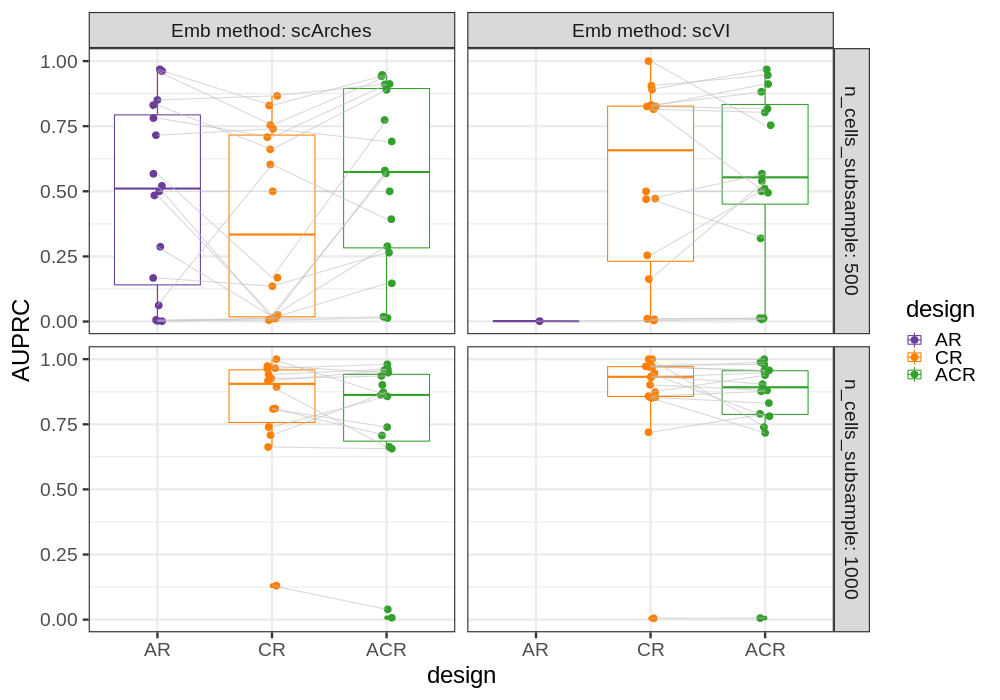

In [53]:
%%R -i AUPRC_df -w 1000 -h 700
AUPRC_df %>%
#     filter(!OOR_state_name %in% c('neutrophil', 'plasmablast', 'erythrocyte', 'plasmacytoid_dendritic_cell')) %>%
    mutate(`Emb method` = emb_method) %>%
    mutate(design = factor(design, levels=c('AR', "CR", 'ACR'))) %>%
    ggplot(aes(design, AUPRC, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    scale_color_brewer(palette='Accent', 
                       labels=c(logFC='DA logFC (ACR design)', 
                           mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                           mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
    theme_bw(base_size=24) +
    facet_grid(n_cells_subsample~`Emb method`, labeller='label_both') +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) 
#     ggsave(paste0(figdir, 'AUPRC_boxplot_design.png'), width=12, height=5) +
#     ggsave(paste0(figdir, 'AUPRC_boxplot_design.pdf'), width=12, height=5)



/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


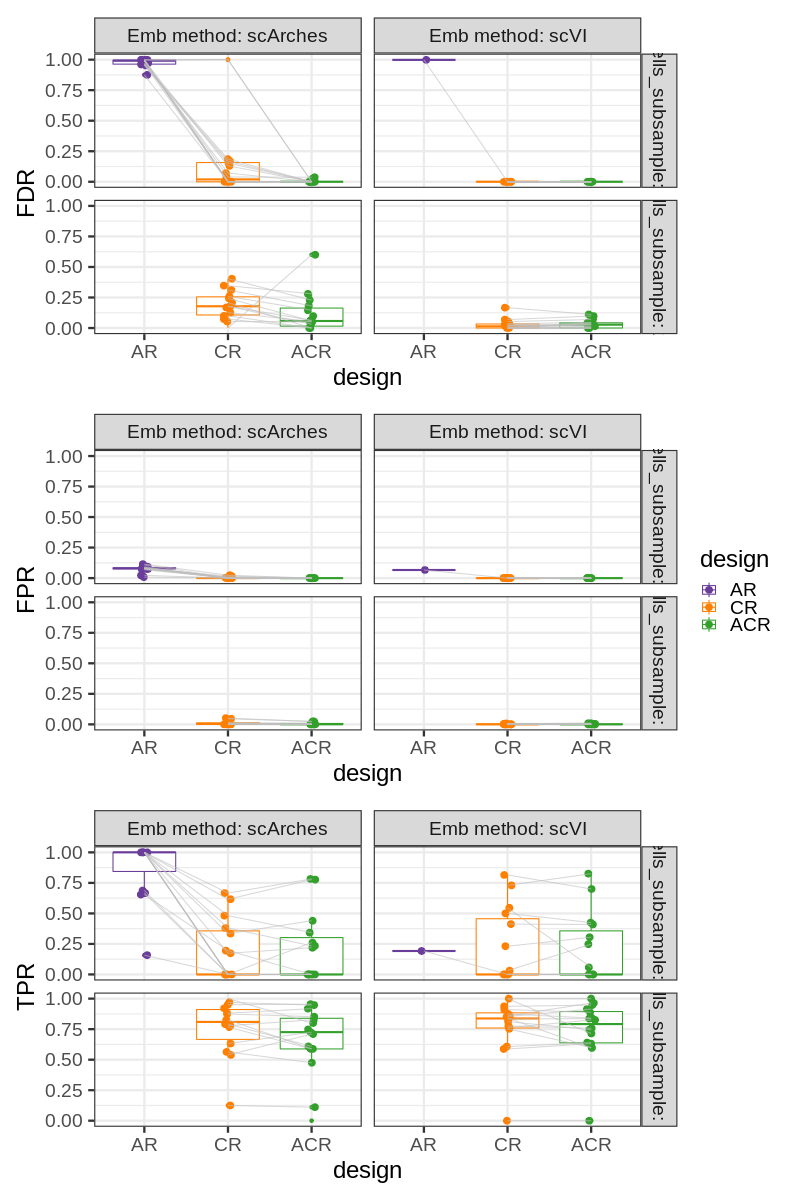

In [52]:
%%R -i TPR_df -w 800 -h 1200
library(patchwork)

pl_df <- TPR_df %>%
    pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
#     filter(!OOR_state_name %in% c('neutrophil', 'plasmablast', 'erythrocyte', 'plasmacytoid_dendritic_cell')) %>%
    mutate(`Emb method` = emb_method) %>%
    mutate(design = factor(design, levels=c('AR', "CR", 'ACR'))) 

pl_ls <- lapply(c('FDR', "FPR", "TPR"), function(m) pl_df %>%
                filter(metric == m) %>%
                ggplot(aes(design, value, color=design)) +
                geom_boxplot() +
                geom_jitter(size=3, width=0.05) +
                geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
                scale_color_brewer(palette='Accent', 
                                   labels=c(logFC='DA logFC (ACR design)', 
                                       mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                                       mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
                theme_bw(base_size=24) +
                ylab(m) + ylim(0,1) +
                facet_grid(n_cells_subsample~`Emb method`, labeller='label_both') +
                scale_color_manual(values=design_palette) +
                theme_bw(base_size=24))

wrap_plots(pl_ls) + plot_layout(ncol=1, guides='collect') 
#     ggsave(paste0(figdir, 'metrics_boxplot_design.png'), width=10, height=10) +
#     ggsave(paste0(figdir, 'metrics_boxplot_design.pdf'), width=10, height=10)


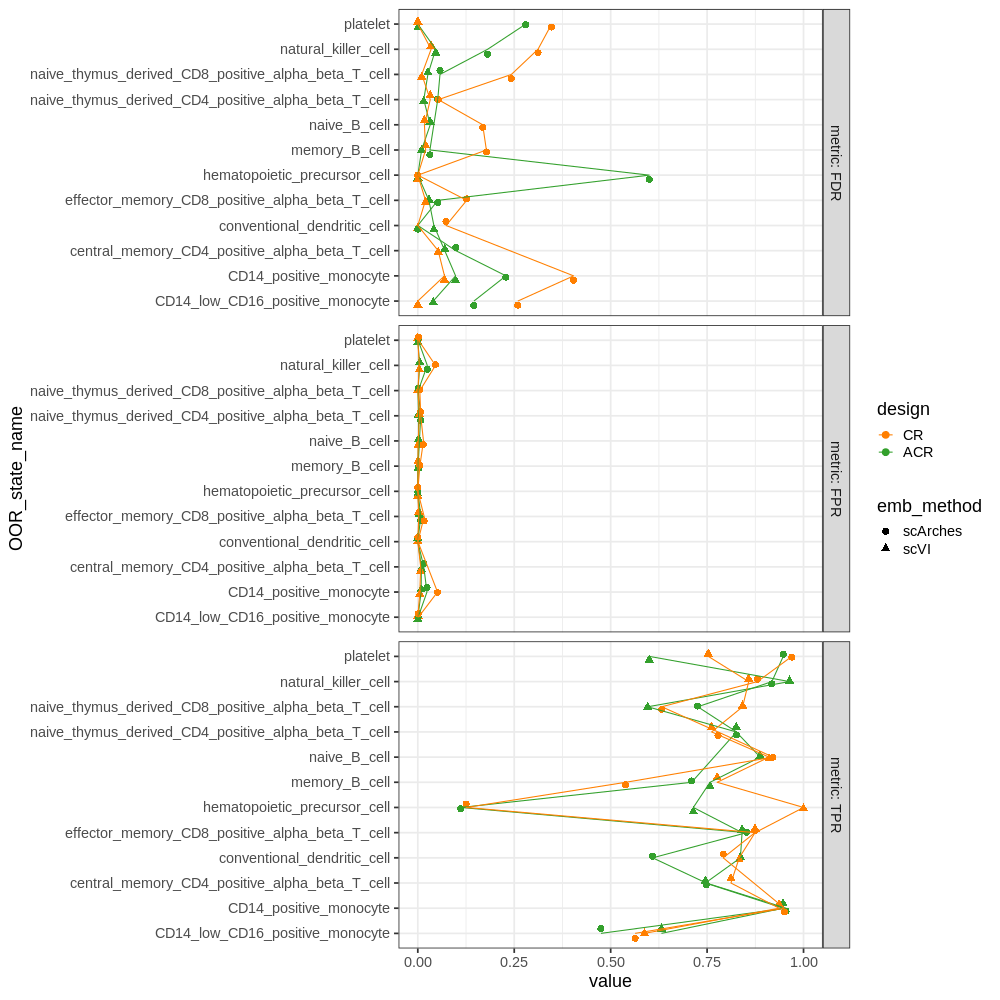

In [48]:
%%R -h 1000 -w 1000
pl_df %>%
filter(n_cells_subsample == 1000) %>%
filter(design != 'AR') %>%
ggplot(aes(OOR_state_name, value, color=design, shape=emb_method)) +
geom_jitter(size=3, width=0.2) +
facet_grid(metric~., labeller='label_both') +
geom_line(aes(group=paste(design, emb_method))) +
coord_flip() +
scale_color_manual(values=design_palette) +
theme_bw(base_size=18)


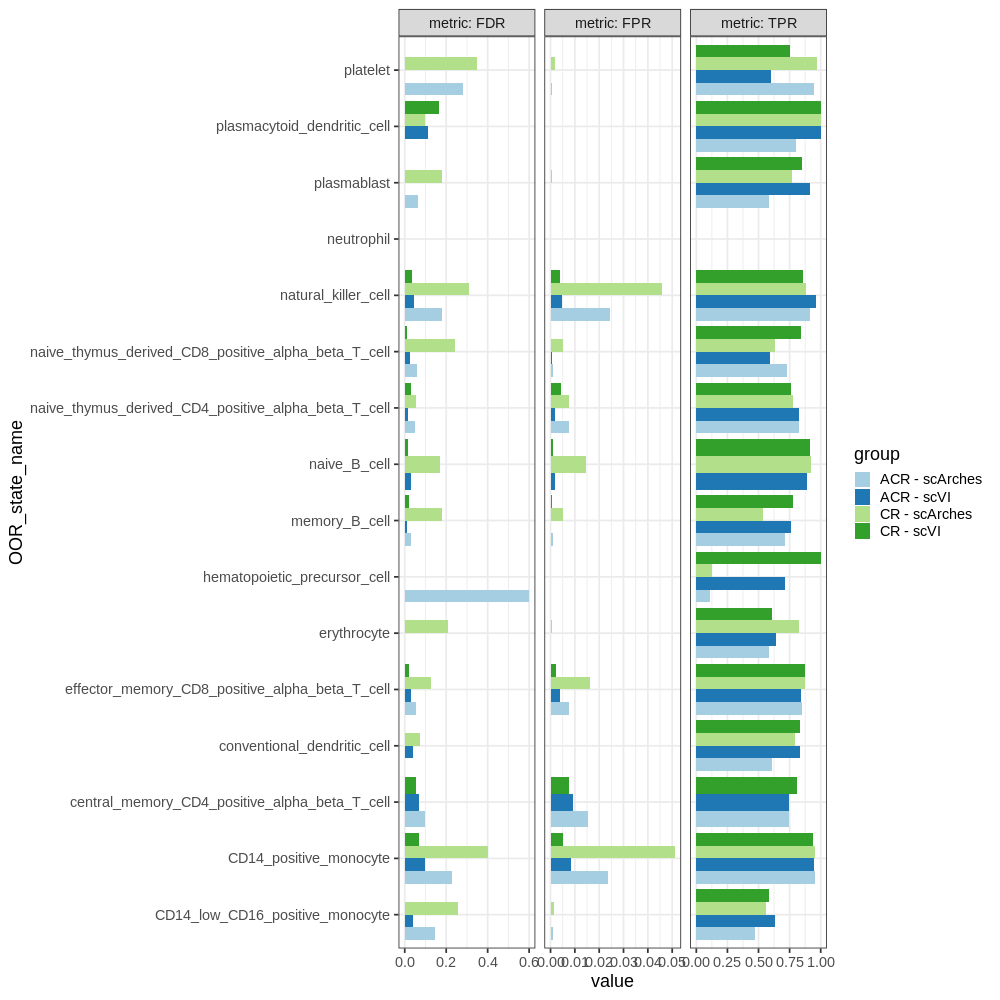

In [69]:
%%R -h 1000 -w 1000
pl_df %>%
filter(n_cells_subsample == 1000) %>%
filter(design != 'AR') %>%
mutate(group = paste(design, '-', emb_method)) %>%
ggplot(aes(OOR_state_name, value, fill=group)) +
geom_col(position='dodge') +
facet_grid(.~metric, labeller='label_both', scales='free') +
coord_flip() +
scale_fill_brewer(palette="Paired") +
theme_bw(base_size=18)


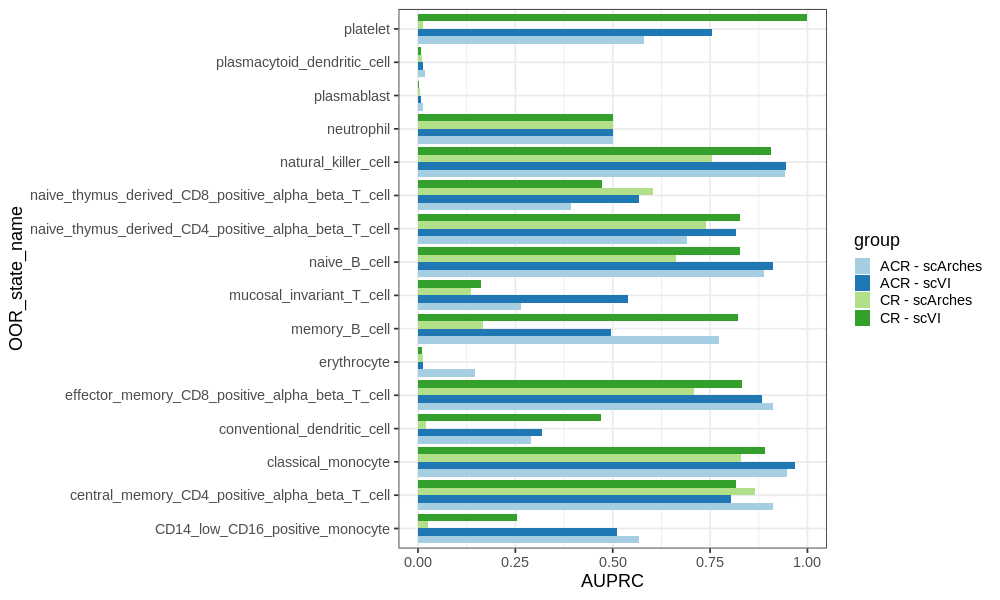

In [62]:
%%R -w 1000 -h 600
AUPRC_df %>%
filter(n_cells_subsample == 500) %>%
filter(design != 'AR') %>%
mutate(group = paste(design, '-', emb_method)) %>%
ggplot(aes(OOR_state_name, AUPRC, fill=group)) +
geom_col(position='dodge') +
# facet_grid(metric~., labeller='label_both') +
coord_flip() +
scale_fill_brewer(palette="Paired") +
theme_bw(base_size=18)


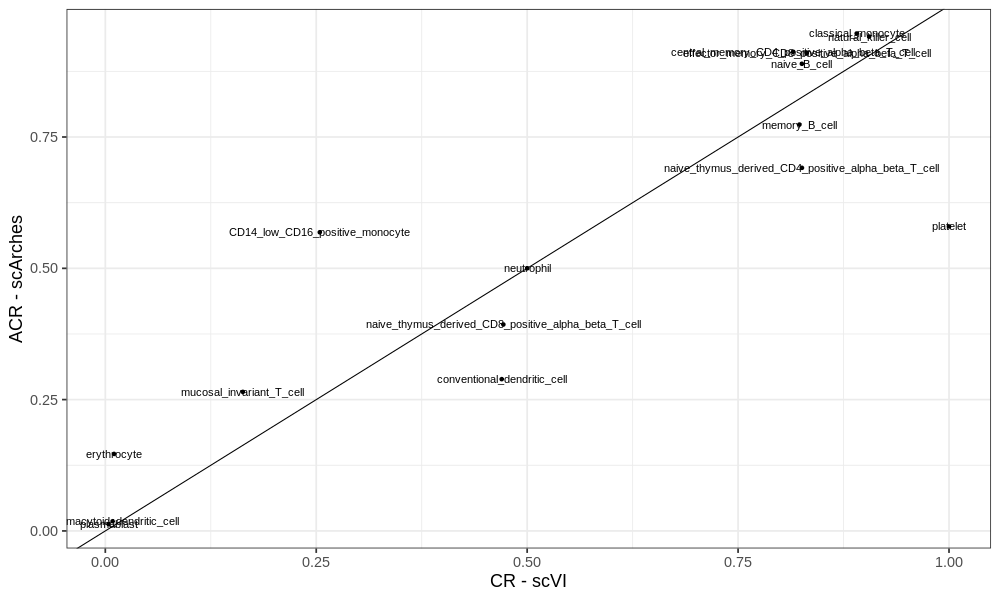

In [197]:
%%R -w 1000 -h 600
AUPRC_df %>%
filter(n_cells_subsample == 500) %>%
filter(design != 'AR') %>%
mutate(group = paste(design, '-', emb_method)) %>%
filter(group %in% c('CR - scVI', 'ACR - scArches')) %>%
select(group, AUPRC, OOR_state_name) %>%
pivot_wider(names_from = group, values_from = AUPRC) %>%
ggplot(aes(`CR - scVI`, `ACR - scArches`, label=OOR_state_name)) +
geom_point() +
geom_text() +
theme_bw(base_size=18) +
geom_abline()


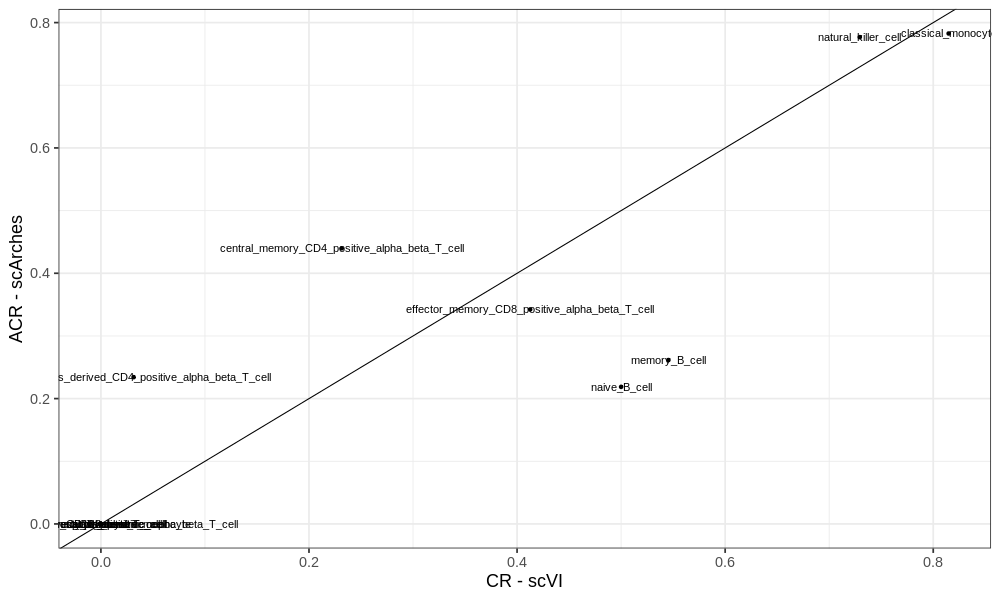

In [198]:
%%R -w 1000 -h 600
pl_df %>%
filter(metric  == 'TPR') %>%
filter(n_cells_subsample == 500) %>%
filter(design != 'AR') %>%
mutate(group = paste(design, '-', emb_method)) %>%
filter(group %in% c('CR - scVI', 'ACR - scArches')) %>%
select(group, value, OOR_state_name) %>%
pivot_wider(names_from = group, values_from = value) %>%
ggplot(aes(`CR - scVI`, `ACR - scArches`, label=OOR_state_name)) +
geom_point() +
geom_text() +
theme_bw(base_size=18) +
geom_abline()


## Effect of HVG selection

In [12]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_') and not x.endswith("withOOR") and not x.endswith(".pkl")]

In [77]:
d='qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

In [152]:
hvg_intersect_df_all = pd.DataFrame()
for d in dirs:
    vars_CR_scvi = sc.read_h5ad(outdir + d +'/model_ctrlquery/adata.h5ad', backed=True).var
    vars_CR_scarches = sc.read_h5ad(outdir + d +'/model_ctrl/adata.h5ad', backed=True).var
    vars_ACR_scvi = sc.read_h5ad(outdir + d +'/model_atlasctrlquery/adata.h5ad', backed=True).var
    vars_ACR_scarches = sc.read_h5ad(outdir + d +'/model_atlas/adata.h5ad', backed=True).var

    ct = d.split('cell_type')[-1].split('_queryBatch')[0]
    hvg_intersect_df = pd.DataFrame(columns = ['design1', 'design2', 'frac_intersect'])
    i = 0

    hvg_intersect_df.loc[i,'frac_intersect'] = np.intersect1d(
        vars_ACR_scarches['gene_id'], vars_ACR_scvi['gene_id']).shape[0]/vars_ACR_scarches.shape[0]
    hvg_intersect_df.loc[i,'design1'] = 'ACR_scArches'
    hvg_intersect_df.loc[i,'design2'] = 'ACR_scVI'
    i += 1 

    hvg_intersect_df.loc[i,'frac_intersect'] = np.intersect1d(
        vars_ACR_scarches['gene_id'], vars_CR_scarches['gene_id']).shape[0]/vars_ACR_scarches.shape[0]
    hvg_intersect_df.loc[i,'design1'] = 'ACR_scArches'
    hvg_intersect_df.loc[i,'design2'] = 'CR_scArches'
    i += 1 

    hvg_intersect_df.loc[i,'frac_intersect'] = np.intersect1d(
        vars_ACR_scarches['gene_id'], vars_CR_scvi['gene_id']).shape[0]/vars_ACR_scarches.shape[0]
    hvg_intersect_df.loc[i,'design1'] = 'ACR_scArches'
    hvg_intersect_df.loc[i,'design2'] = 'CR_scVI'
    i += 1 

    hvg_intersect_df.loc[i,'frac_intersect'] = np.intersect1d(
        vars_CR_scarches['gene_id'], vars_CR_scvi['gene_id']).shape[0]/vars_ACR_scarches.shape[0]
    hvg_intersect_df.loc[i,'design1'] = 'CR_scArches'
    hvg_intersect_df.loc[i,'design2'] = 'CR_scVI'

    hvg_intersect_df['OOR_state_name'] = ct
    hvg_intersect_df_all = pd.concat([hvg_intersect_df_all, hvg_intersect_df])

In [172]:
hvg_intersect_df_all

,design1,design2,frac_intersect,OOR_state_name
0,ACR_scArches,ACR_scVI,0.9804,memory_B_cell
1,ACR_scArches,CR_scArches,0.65,memory_B_cell
2,ACR_scArches,CR_scVI,0.684,memory_B_cell
3,CR_scArches,CR_scVI,0.8178,memory_B_cell
0,ACR_scArches,ACR_scVI,0.9798,conventional_dendritic_cell
...,...,...,...,...
3,CR_scArches,CR_scVI,0.8172,mucosal_invariant_T_cell
0,ACR_scArches,ACR_scVI,0.98,CD14_low_CD16_positive_monocyte
1,ACR_scArches,CR_scArches,0.6442,CD14_low_CD16_positive_monocyte
2,ACR_scArches,CR_scVI,0.6794,CD14_low_CD16_positive_monocyte


In [159]:
hvg_intersect_df_all = hvg_intersect_df_all.convert_dtypes()

In [160]:
%%R -i hvg_intersect_df_all
head(hvg_intersect_df_all)

       design1     design2 frac_intersect              OOR_state_name
1 ACR_scArches    ACR_scVI         0.9804               memory_B_cell
2 ACR_scArches CR_scArches         0.6500               memory_B_cell
3 ACR_scArches     CR_scVI         0.6840               memory_B_cell
4  CR_scArches     CR_scVI         0.8178               memory_B_cell
5 ACR_scArches    ACR_scVI         0.9798 conventional_dendritic_cell
6 ACR_scArches CR_scArches         0.6446 conventional_dendritic_cell


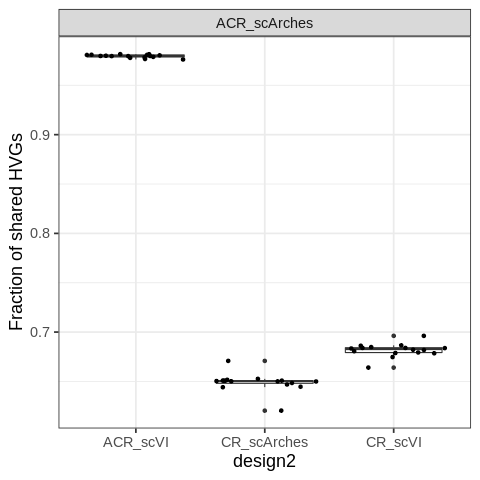

In [170]:
%%R 
hvg_intersect_df_all %>%
filter(design1 != 'CR_scArches') %>%
ggplot(aes(design2, frac_intersect)) +
geom_boxplot() +
geom_jitter() +
theme_bw(base_size=18) +
ylab("Fraction of shared HVGs") +
facet_wrap(design1~.)

<AxesSubplot: xlabel='frac_intersect', ylabel='OOR_state_name'>

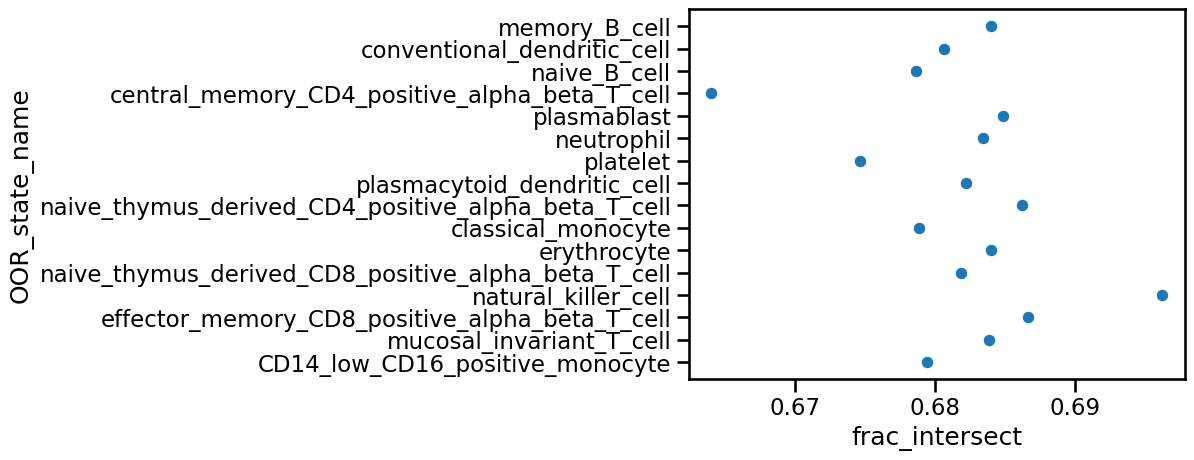

In [177]:

sns.scatterplot(data=hvg_intersect_df_all[(hvg_intersect_df_all['design1'] == 'ACR_scArches') & (hvg_intersect_df_all['design2'] == 'CR_scVI')], 
            y='OOR_state_name', x='frac_intersect')

In [171]:
print(np.intersect1d(vars_ACR_scarches['gene_id'], vars_CR_scarches['gene_id']).shape[0]/5000)
print(np.intersect1d(vars_ACR_scarches['gene_id'], vars_CR_scvi['gene_id']).shape[0]/5000)
print(np.intersect1d(vars_CR_scarches['gene_id'], vars_CR_scvi['gene_id']).shape[0]/5000)

0.6442
0.6794
0.8176


In [134]:
def hvg_batch(
    adata,
    batch_key=None,
    target_genes=2000,
    flavor="cell_ranger",
    n_bins=20,
    adataOut=False,
):
    """Batch-aware highly variable gene selection
    Method to select HVGs based on mean dispersions of genes that are highly
    variable genes in all batches. Using a the top target_genes per batch by
    average normalize dispersion. If target genes still hasn't been reached,
    then HVGs in all but one batches are used to fill up. This is continued
    until HVGs in a single batch are considered.
    :param adata: ``anndata`` object
    :param batch: ``adata.obs`` column
    :param target_genes: maximum number of genes (intersection reduces the number of genes)
    :param flavor: parameter for ``scanpy.pp.highly_variable_genes``
    :param n_bins: parameter for ``scanpy.pp.highly_variable_genes``
    :param adataOut: whether to return an ``anndata`` object or a list of highly variable genes
    """

    utils.check_adata(adata)
    if batch_key is not None:
        utils.check_batch(batch_key, adata.obs)

    adata_hvg = adata if adataOut else adata.copy()

    n_batches = len(adata_hvg.obs[batch_key].cat.categories)

    # Calculate double target genes per dataset
    sc.pp.highly_variable_genes(
        adata_hvg,
        flavor=flavor,
        n_top_genes=target_genes,
        n_bins=n_bins,
        batch_key=batch_key,
    )

    nbatch1_dispersions = adata_hvg.var["dispersions_norm"][
        adata_hvg.var.highly_variable_nbatches
        > len(adata_hvg.obs[batch_key].cat.categories) - 1
    ]

    nbatch1_dispersions.sort_values(ascending=False, inplace=True)

    if len(nbatch1_dispersions) > target_genes:
        hvg = nbatch1_dispersions.index[:target_genes]

    else:
        enough = False
        print(f"Using {len(nbatch1_dispersions)} HVGs from full intersect set")
        hvg = nbatch1_dispersions.index[:]
        not_n_batches = 1

        while not enough:
            target_genes_diff = target_genes - len(hvg)

            tmp_dispersions = adata_hvg.var["dispersions_norm"][
                adata_hvg.var.highly_variable_nbatches == (n_batches - not_n_batches)
            ]

            if len(tmp_dispersions) < target_genes_diff:
                print(
                    f"Using {len(tmp_dispersions)} HVGs from n_batch-{not_n_batches} set"
                )
                hvg = hvg.append(tmp_dispersions.index)
                not_n_batches += 1

            else:
                print(
                    f"Using {target_genes_diff} HVGs from n_batch-{not_n_batches} set"
                )
                tmp_dispersions.sort_values(ascending=False, inplace=True)
                hvg = hvg.append(tmp_dispersions.index[:target_genes_diff])
                enough = True

    print(f"Using {len(hvg)} HVGs")

    if not adataOut:
        del adata_hvg
        return hvg.tolist()
    else:
        return adata_hvg[:, hvg].copy()

(1597,)

In [116]:
import celltypist

# Match cell types 
celltypist_anno_dict = {
'natural_killer_cell':'NK cells',
 'memory_B_cell':'Memory B cells',
 'central_memory_CD4_positive_alpha_beta_T_cell':'Tem/Effector helper T cells',
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell':'Tcm/Naive helper T cells',
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell':'Tcm/Naive cytotoxic T cells',
 'naive_B_cell':'Naive B cells',
 'classical_monocyte':'Classical monocytes',
 'conventional_dendritic_cell':'DC',
 'effector_memory_CD8_positive_alpha_beta_T_cell':'Tem/Effector cytotoxic T cells',
 'mucosal_invariant_T_cell':'MAIT cells',
 'plasmacytoid_dendritic_cell':'pDC',
 'platelet':'Megakaryocytes/platelets',
 'plasmablast':'Plasma cells',
 'erythrocyte':'Erythrocytes',
 'CD14_low_CD16_positive_monocyte':'Non-classical monocytes'
}

In [118]:
# Get celltypist model for immune cells
ct_model = celltypist.Model.load('Immune_All_Low.pkl')
ct_markers = ct_model.extract_top_markers(celltypist_anno_dict[ct], top_n=100)

In [129]:
ct_markers[pd.Series(ct_markers).isin(vars_ACR_scarches['gene_name'])]

array(['RGS1', 'LYZ', 'HLA-DQA1', 'HLA-DQB1', 'ENHO', 'CXCL10', 'FCER1A',
       'CST7', 'HLA-DPB1', 'SERF1A', 'MS4A6A', 'C9orf139', 'PTGDS'],
      dtype=object)

In [130]:
vars_CR_scvi['gene_name']

ENSG00000122335       SERAC1
ENSG00000175548       ALG10B
ENSG00000100330        MTMR3
ENSG00000172260        NEGR1
ENSG00000134321        RSAD2
                     ...    
ENSG00000172795         DCP2
ENSG00000164114         MAP9
ENSG00000138756        BMP2K
ENSG00000150456    EEF1AKMT1
ENSG00000106780        MEGF9
Name: gene_name, Length: 5000, dtype: category
Categories (5000, object): ['A1BG', 'A2M', 'A2M-AS1', 'AAK1', ..., 'ZSWIM3', 'ZXDB', 'ZYX', 'ZZEF1']

In [127]:
'FCER1A' in vars_CR_scvi['gene_name'].tolist()
'FCER1A' in vars_CR_scarches['gene_name'].tolist()

True

In [122]:
ct_markers[pd.Series(ct_markers).isin(vars_CR_scvi['gene_name'])]

array(['RGS1', 'LYZ', 'HLA-DQA1', 'HLA-DQB1', 'ENHO', 'CXCL10', 'FCER1A',
       'PPM1J', 'SLC5A2', 'MATN1-AS1', 'CST7', 'HLA-DPB1', 'SERF1A',
       'MS4A6A', 'C9orf139', 'PTGDS'], dtype=object)

---

In [152]:
def read_oor_design_output(simdir, ref_design, embedding_method, diff_method, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    if ref_design == 'AR' and embedding_method == 'scArches' and diff_method == 'milo': 
        h5ad_file = simdir + f'/ar_design.h5ad'
    else:
        h5ad_file = simdir + f'/{ref_design}_design.{embedding_method}_{diff_method}.h5ad'
    if diff_method == 'milo':
        try:
            adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=True)
        except:
            print(f'skipping {ref_design} design')
            return(None)
    else:
        try:
            adata = sc.read_h5ad(h5ad_file, backed=True)
        except:
            print(f'skipping {ref_design} design')
            return(None)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

def harmonize_output(adata, signif_alpha=0.1):
    sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()

def parse_design(adata, ref_design):
#     if 'sample_adata' not in adata.uns:
    harmonize_output(adata)
    perturb_pop = adata.obs['OOR_state_name'].unique()[0]
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = perturb_pop
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = perturb_pop
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = perturb_pop
    return(nhoods_df, tpr_df, auprc_df)

In [173]:
dirs

['qPBMC_1000cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_1000cells_demo_perturb_cell_typehematopoietic_precursor_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_1000cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_1000cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_1000cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_1000cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_1000cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_1000cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPB

In [170]:
import milopy

In [200]:
adata.obs['OOR_state']

10_1038_s41591_021_01329_2-TCGAGGCAGGGTGTGT-MH8919227    0
10_1038_s41591_021_01329_2-CGATGGCAGTGCAAGC-MH8919227    0
10_1038_s41591_021_01329_2-CTCGGAGTCGTCCGTT-MH8919227    0
10_1038_s41591_021_01329_2-TAGGCATAGCCACGTC-MH8919227    0
10_1038_s41591_021_01329_2-GACAGAGTCTCGAGTA-MH8919227    0
                                                        ..
10_1038_s41591_021_01329_2-TAGGCATGTCTGATCA-MH8919278    0
10_1038_s41591_021_01329_2-CTGCTGTAGATATGCA-MH8919278    0
10_1038_s41591_021_01329_2-ATCGAGTAGCTGCGAA-MH8919278    0
10_1038_s41591_021_01329_2-AGTTGGTCAGTCAGCC-MH8919278    0
10_1038_s41591_021_01329_2-BGCV12_GAAGCAGTCTTGTACT-1     0
Name: OOR_state, Length: 14039, dtype: int64

Reading conventional_dendritic_cell



/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_ad

Reading conventional_dendritic_cell



/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_ad

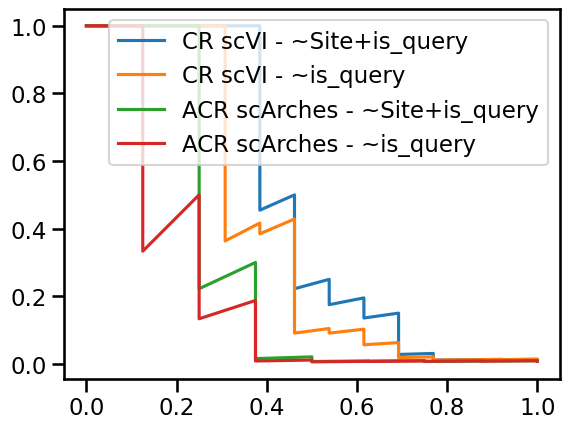

In [183]:
simdir = outdir + 'qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'
# adata = milopy.utils.read_milo_adata(
#                 simdir+'/CR_design.scVI_milo.h5ad', backed=True)
adata = read_oor_design_output(simdir, ref_design='CR', embedding_method='scVI', population_obs='cell_type', diff_method='milo')
adata.uns['nhood_adata'] = adata.uns['nhood_adata'].to_memory()

milopy.core.DA_nhoods(adata, design='~Site+is_query')
nhoods_df1, tpr_df1, auprc_df1 = parse_design(adata, ref_design='CR')
milo_res = adata.uns['nhood_adata'].obs.copy()

milopy.core.DA_nhoods(adata, design='~is_query')
nhoods_df2, tpr_df2, auprc_df2 = parse_design(adata, ref_design='CR')
milo_res_new = adata.uns['nhood_adata'].obs.copy()

plt.plot(auprc_df1.Recall, auprc_df1.Precision, label='CR scVI - ~Site+is_query')
plt.plot(auprc_df2.Recall, auprc_df2.Precision, label='CR scVI - ~is_query');
plt.legend()

adata = read_oor_design_output(simdir, ref_design='ACR', embedding_method='scArches', population_obs='cell_type', diff_method='milo')
adata.uns['nhood_adata'] = adata.uns['nhood_adata'].to_memory()

milopy.core.DA_nhoods(adata, design='~Site+is_query')
nhoods_df1, tpr_df1, auprc_df1 = parse_design(adata, ref_design='CR')
milo_res = adata.uns['nhood_adata'].obs.copy()

milopy.core.DA_nhoods(adata, design='~is_query')
nhoods_df2, tpr_df2, auprc_df2 = parse_design(adata, ref_design='CR')
milo_res_new = adata.uns['nhood_adata'].obs.copy()

plt.plot(auprc_df1.Recall, auprc_df1.Precision, label='ACR scArches - ~Site+is_query')
plt.plot(auprc_df2.Recall, auprc_df2.Precision, label='ACR scArches - ~is_query');
plt.legend()